In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import keras 
np.random.seed(1)

import sklearn.metrics as ms
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Input, BatchNormalization, Dot, dot
from keras.models import Sequential, Model

from keras import backend as K
from keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Reshape, LayerNormalization, Add, Lambda, Conv1D, Flatten
from tensorflow.keras.layers import Dense, Dropout, LSTM, Layer, Concatenate, Multiply, Bidirectional
from keras.backend import expand_dims
from keras.optimizers import Adam, RMSprop

tf.random.set_seed(1);

In [ ]:
'''
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/USYD-CS21"

os.chdir(path)
os.listdir(path)
'''

'\nimport os\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\npath = "/content/drive/My Drive/USYD-CS21"\n\nos.chdir(path)\nos.listdir(path)\n'

In [ ]:
df_all = pd.read_csv('../data/PV.csv')
df_all.head()

,time,power (W),airtemp,humidity,insolation,windspeed,hour,d1_power,d2_power,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,Ghi,WindDirection10m,Zenith
0,2016-01-01 05:00:00,685,18.8,66.0,2.8,1.6,5,885.0,0.0,95.0,37.2,13.3,374.0,141.0,101.0,475.0,148.0,43.0
1,2016-01-01 05:01:00,935,18.8,66.1,0.0,1.0,5,990.0,100.0,95.2,34.3,13.3,373.2,169.8,121.4,494.6,148.0,43.2
2,2016-01-01 05:02:00,980,18.8,66.1,2.7,1.0,5,1240.0,280.0,95.4,31.4,13.3,372.4,198.6,141.8,514.2,148.0,43.4
3,2016-01-01 05:03:00,1185,18.8,66.2,4.9,1.0,5,1490.0,425.0,95.6,28.6,13.4,371.6,227.4,162.2,533.8,148.0,43.6
4,2016-01-01 05:04:00,1495,18.8,66.1,4.9,1.0,5,1590.0,485.0,95.8,25.7,13.4,370.8,256.2,182.6,553.4,148.0,43.8


In [ ]:
df_all = pd.read_csv('../data/kmlab3.csv')
df_all.head()

,time,power (W),airtemp,humidity,insolation,windspeed,AirTemp,Azimuth,CloudOpacity,DewpointTemp,...,RelativeHumidity,WindSpeed10m,Zenith,WindDirection10m_sin,WindDirection10m_cos,winddirection_sin,winddirection_cos,tempDiff,dist2peak,km_label
0,2016-01-01 05:00:00,685,18.8,66.0,2.8,1.6,26.1,95.0,37.2,13.3,...,45.4,3.6,43.0,-0.338333,-0.941026,0.733211,0.680001,-7.3,456,1
1,2016-01-01 05:01:00,935,18.8,66.1,0.0,1.0,26.1,95.2,34.3,13.3,...,45.4,3.6,43.2,-0.338333,-0.941026,0.733211,0.680001,-7.3,455,1
2,2016-01-01 05:02:00,980,18.8,66.1,2.7,1.0,26.1,95.4,31.4,13.3,...,45.4,3.6,43.4,-0.338333,-0.941026,0.733211,0.680001,-7.3,454,1
3,2016-01-01 05:03:00,1185,18.8,66.2,4.9,1.0,26.1,95.6,28.6,13.4,...,45.4,3.6,43.6,-0.338333,-0.941026,0.733211,0.680001,-7.3,453,1
4,2016-01-01 05:04:00,1495,18.8,66.1,4.9,1.0,26.1,95.8,25.7,13.4,...,45.4,3.6,43.8,-0.338333,-0.941026,0.733211,0.680001,-7.3,452,1


In [ ]:
from sklearn.model_selection import train_test_split

df_power = df_all['power (W)'].values
df_power = np.reshape(df_power, (df_power.shape[0], 1))
df_weather = df_all.iloc[:, 2:].values
df_both = df_all.iloc[:, 1:].values

time_window = 15
df_train, df_test = train_test_split(df_all, test_size=0.1, shuffle=False)

train_size = len(df_train)
print(len(df_all))
print('Train Size: ', len(df_train))
print('Test Size: ', len(df_test))

612781
Train Size:  551502
Test Size:  61279


In [ ]:
df_test.head()

,time,power (W),airtemp,humidity,insolation,windspeed,AirTemp,Azimuth,CloudOpacity,DewpointTemp,...,RelativeHumidity,WindSpeed10m,Zenith,WindDirection10m_sin,WindDirection10m_cos,winddirection_sin,winddirection_cos,tempDiff,dist2peak,km_label
551502,2017-10-19 06:51:00,35600,19.2,79.7,129.2,0.3,20.4,94.0,10.7,15.3,...,72.8,3.2,77.2,-0.176076,-0.984377,-0.176046,0.984382,-1.2,155,3
551503,2017-10-19 06:52:00,48150,19.3,79.3,124.2,0.3,20.4,94.0,11.2,15.3,...,72.9,3.2,77.4,-0.176076,-0.984377,-0.176046,0.984382,-1.1,154,3
551504,2017-10-19 06:53:00,40250,19.3,79.3,129.2,0.6,20.3,94.0,11.6,15.4,...,72.9,3.2,77.6,-0.176076,-0.984377,-0.176046,0.984382,-1.0,153,3
551505,2017-10-19 06:54:00,50600,19.3,79.2,134.2,0.6,20.3,94.0,12.1,15.4,...,73.0,3.2,77.8,-0.176076,-0.984377,-0.176046,0.984382,-1.0,152,3
551506,2017-10-19 06:55:00,63550,19.3,79.1,149.2,0.3,20.3,94.0,12.5,15.4,...,73.1,3.2,78.0,-0.176076,-0.984377,-0.176046,0.984382,-1.0,151,3


###  Normalization - MinMaxScaler using traing data

Text(0.5, 1.0, 'Time series after scaling')

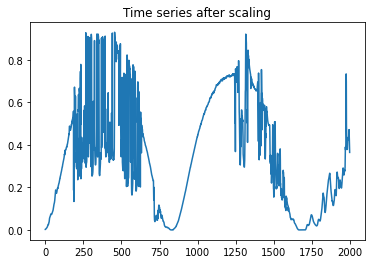

In [ ]:
# Scale the data to the range of [0,1]
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler using only train dataset
fitted_transformer_power = scaler1.fit(df_power)
fitted_transformer_weather = scaler2.fit(df_weather)
fitted_transformer_all = scaler3.fit(df_both)

# Transforming using trained scaler 
norm_power = fitted_transformer_power.transform(df_power)
norm_weather = fitted_transformer_weather.transform(df_weather)
norm_all = fitted_transformer_all.transform(df_both)

plt.figure()
plt.plot(norm_power[1:2000])
plt.title('Time series after scaling')

Text(0.5, 1.0, 'Time series after scaling on temperature')

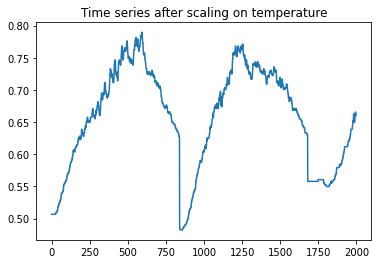

In [ ]:
plt.figure()
plt.plot(norm_weather[1:2000, 0])
plt.title('Time series after scaling on temperature')

### Set up data input with window size

In [ ]:
'''
Xall, Yall = [], [] #scaled
Xall_not_scaled, Yall_not_scaled = [], [] #not scaled


for i in range(time_window, len(data)): #(15,612781)
    Xall.append(data[i-time_window:i, 0]) #(0:15,0),(1:16,0)...(612766:612781,0)
    Xall_not_scaled.append(power[i-time_window:i, 0]) #(0:15,0),(1:16,0)
    Yall.append(data[i, 0]) #[15,0]
    Yall_not_scaled.append(power[i, 0])
    
# scaled data
Xall = np.array(Xall)    # Convert them from list to array   
Yall = np.array(Yall)
# original data not scaled
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)


Xtrain = Xall[:train_size, :] #(:551320,:)
Ytrain = Yall[:train_size] #(:551320)

Xtest = Xall[-val_size:, :] #(-61446:,:)
Ytest = Yall[-val_size:] #(-61446:)
print('Xtrain:',Xtrain.shape,'Ytrain:',Ytrain.shape)
print('Xall:',Xall.shape,'Yall:',Yall.shape)

# For time series and LSTM layer we need to reshape into 3D array 
Xtrain_in = Xtrain.reshape(Xtrain.shape[0], time_window, 1)
Xall_in = Xall.reshape(Xall.shape[0],time_window,1)
Xtest_in =Xtest.reshape(Xtest.shape[0], time_window, 1)
print('Xtrain_in:',Xall_in.shape,'Xtest_in:',Xtest_in.shape)
'''

"\nXall, Yall = [], [] #scaled\nXall_not_scaled, Yall_not_scaled = [], [] #not scaled\n\n\nfor i in range(time_window, len(data)): #(15,612781)\n    Xall.append(data[i-time_window:i, 0]) #(0:15,0),(1:16,0)...(612766:612781,0)\n    Xall_not_scaled.append(power[i-time_window:i, 0]) #(0:15,0),(1:16,0)\n    Yall.append(data[i, 0]) #[15,0]\n    Yall_not_scaled.append(power[i, 0])\n    \n# scaled data\nXall = np.array(Xall)    # Convert them from list to array   \nYall = np.array(Yall)\n# original data not scaled\nXall_not_scaled = np.array(Xall_not_scaled)\nYall_not_scaled = np.array(Yall_not_scaled)\n\n\nXtrain = Xall[:train_size, :] #(:551320,:)\nYtrain = Yall[:train_size] #(:551320)\n\nXtest = Xall[-val_size:, :] #(-61446:,:)\nYtest = Yall[-val_size:] #(-61446:)\nprint('Xtrain:',Xtrain.shape,'Ytrain:',Ytrain.shape)\nprint('Xall:',Xall.shape,'Yall:',Yall.shape)\n\n# For time series and LSTM layer we need to reshape into 3D array \nXtrain_in = Xtrain.reshape(Xtrain.shape[0], time_window, 1

In [ ]:
X_power, Y_power = [], []
X_weather = []
X_all = []
#X_power = np.zeros((norm_power.shape[0]-time_window,\
#                    time_window, norm_power.shape[1]))

for i in range(time_window, len(norm_power)): 
    X_power.append(norm_power[i-time_window: i])
    X_weather.append(norm_weather[i-time_window:i, :])
    X_all.append(norm_all[i-time_window:i, :])
    Y_power.append(norm_power[i])
    
    
Xtrain_power = np.array(X_power[:train_size])
Xtrain_weather = np.array(X_weather[:train_size])
Xtrain_all = np.array(X_all[:train_size])
Ytrain_power = np.array(Y_power[:train_size])
print('Training X Power Size:',Xtrain_power.shape,\
      'Training X Weather Size:',Xtrain_weather.shape,\
      'Training X P&W Size', Xtrain_all.shape,\
      'Training Y Power Size:',Ytrain_power.shape)


Xtest_power = np.array(X_power[train_size:])
Xtest_weather = np.array(X_weather[train_size:])
Xtest_all = np.array(X_all[train_size:])
Ytest_power = np.array(Y_power[train_size:])
print('Test X Power Size:',Xtest_power.shape,\
      'Test X Weather Size:',Xtest_weather.shape,\
      'Test X P&W Size:', Xtest_all.shape,\
      'Test Y Power Size:',Ytest_power.shape)

Training X Power Size: (551502, 15, 1) Training X Weather Size: (551502, 15, 22) Training X P&W Size (551502, 15, 23) Training Y Power Size: (551502, 1)
Test X Power Size: (61264, 15, 1) Test X Weather Size: (61264, 15, 22) Test X P&W Size: (61264, 15, 23) Test Y Power Size: (61264, 1)


## LSTM

### Single layered Traditional LSTM

In [ ]:
def lstm_model(x):
    x = Input(shape=x[1:])
    lstm_out = LSTM(100,input_shape=(None, 1), activation='tanh',return_sequences=False)(x)
    out = Dense(1,activation='linear')(lstm_out)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_lstm1 = lstm_model(Xtrain_power.shape)
model_lstm1.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 15, 1)]           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_472 (Dense)            (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor='loss', restore_best_weights=True,\
                           patience=5, verbose=1)


def lr_scheduler(epoch, lr):
    lr *= 0.5**(epoch//3)
    return lr

my_cb = [LearningRateScheduler(lr_scheduler)]

epoch=10
batch_size=256

In [ ]:
print('-'*30)
print('Fitting LSTM model...')
print('-'*30)
history=model_lstm1.fit(Xtrain_power, Ytrain_power, validation_split=0.2, batch_size=batch_size,\
                   epochs=epoch, callbacks=my_cb, verbose=1)

------------------------------
Fitting LSTM model...
------------------------------
Epoch 1/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0060 - mae: 0.0342 - val_loss: 0.0019 - val_mae: 0.0151 2s - l - ETA: 1s - l
Epoch 2/10
1724/1724 [==============================] - 25s 15ms/step - loss: 0.0050 - mae: 0.0304 - val_loss: 0.0020 - val_mae: 0.0197
Epoch 3/10
1724/1724 [==============================] - 19s 11ms/step - loss: 0.0049 - mae: 0.0304 - val_loss: 0.0019 - val_mae: 0.0166
Epoch 4/10
1724/1724 [==============================] - 20s 12ms/step - loss: 0.0049 - mae: 0.0290 - val_loss: 0.0018 - val_mae: 0.0146
Epoch 5/10
1724/1724 [==============================] - 60s 35ms/step - loss: 0.0048 - mae: 0.0284 - val_loss: 0.0018 - val_mae: 0.0142
Epoch 6/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0048 - mae: 0.0277 - val_loss: 0.0018 - val_mae: 0.0140
Epoch 7/10
1724/1724 [==============================] - 16s 9ms/step - loss: 0.

### LSTM model on Weather Features

In [ ]:
model_lstm_w = lstm_model(Xtrain_weather.shape)
model_lstm_w.summary()
print('-'*30)
print('Fitting model on Weather Features...')
print('-'*30)
history_lstm_w=model_lstm_w.fit(Xtrain_weather, Ytrain_power, validation_split=0.2, batch_size=batch_size,\
                   epochs=epoch, callbacks=my_cb, verbose=1)

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 15, 22)]          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 100)               49200     
_________________________________________________________________
dense_473 (Dense)            (None, 1)                 101       
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________
------------------------------
Fitting model on Weather Features...
------------------------------
Epoch 1/10
1724/1724 [==============================] - 18s 11ms/step - loss: 0.0207 - mae: 0.0824 - val_loss: 0.0067 - val_mae: 0.0519
Epoch 2/10
1724/1724 [==============================] - 18s 11ms/step - loss: 0.0101 - mae: 0.0623 - val_loss: 0.0050 - val_mae: 0.0463
Epoch 3/

### Two layered LSTM

In [ ]:
def lstm_model2(x):
    x = Input(shape=x[1:])
    lstm_out = LSTM(100, activation='tanh',return_sequences=True)(x)
    #bn = BatchNormalization()(lstm_out)
    out = Dense(x.shape[-1], activation='linear')(lstm_out)
    lstm_out = LSTM(100,input_shape=(None, 1), activation='tanh',return_sequences=False)(out)
    out = Dense(1,activation='linear')(lstm_out)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_lstm2 = lstm_model2(Xtrain_power.shape)
model_lstm2.summary()

print('-'*30)
print('Fitting additional LSTM layer model...')
print('-'*30)
history_lstm2=model_lstm2.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 15, 1)]           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 15, 100)           40800     
_________________________________________________________________
dense_474 (Dense)            (None, 15, 1)             101       
_________________________________________________________________
lstm_41 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_475 (Dense)            (None, 1)                 101       
Total params: 81,802
Trainable params: 81,802
Non-trainable params: 0
_________________________________________________________________
------------------------------
Fitting additional LSTM layer model...
------------------------------
Epoch 1/10
172

In [ ]:
def bilstm_model(x):
    x = Input(shape=x[1:])
    lstm_out = Bidirectional(LSTM(50, return_sequences=False))(x)
    #out = Dense(x.shape[-1], activation='linear')(lstm_out)
    out = Dense(1,activation='linear')(lstm_out)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_bilstm = bilstm_model(Xtrain_power.shape)
model_bilstm.summary()

Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 15, 1)]           0         
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 100)               20800     
_________________________________________________________________
dense_592 (Dense)            (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('-'*30)
print('Fitting additional LSTM layer model...')
print('-'*30)
history_bilstm=model_bilstm.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

------------------------------
Fitting additional LSTM layer model...
------------------------------
Epoch 1/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0053 - mae: 0.0326 - val_loss: 0.0019 - val_mae: 0.0149
Epoch 2/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0023 - val_mae: 0.0245
Epoch 3/10
1724/1724 [==============================] - 34s 20ms/step - loss: 0.0049 - mae: 0.0301 - val_loss: 0.0019 - val_mae: 0.0161 loss: 0.0049 - mae: 0 - ETA:
Epoch 4/10
1724/1724 [==============================] - 37s 22ms/step - loss: 0.0048 - mae: 0.0288 - val_loss: 0.0018 - val_mae: 0.0156
Epoch 5/10
1724/1724 [==============================] - 31s 18ms/step - loss: 0.0048 - mae: 0.0279 - val_loss: 0.0018 - val_mae: 0.01390.0048 - mae - ETA: 0s - loss: 0.0048 - mae
Epoch 6/10
1724/1724 [==============================] - 30s 17ms/step - loss: 0.0047 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0143
Epoch 7/10


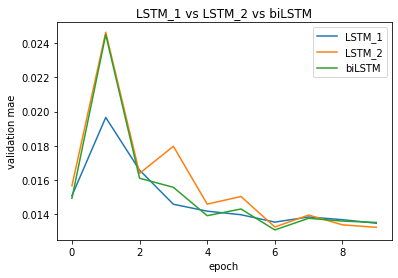

In [ ]:
plt.plot(history.history['val_mae'])
plt.plot(history_lstm2.history['val_mae'])
plt.plot(history_bilstm.history['val_mae'])
plt.title('LSTM_1 vs LSTM_2 vs biLSTM')
plt.ylabel('validation mae')
plt.xlabel('epoch')
plt.legend(['LSTM_1', 'LSTM_2', 'biLSTM'], loc='upper right')
plt.show()


### LSTM with Attetion

In [ ]:
### A basic ALSTM with one LSTM layer and attention

def alstm_model1(x):
    x = Input(shape=x[1:])
    lstm_out, hidden, _ = LSTM(100, activation='tanh',\
                            return_sequences=True, return_state=True)(x)    
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    out = Dot(axes=(2, 1))([weights, lstm_out])
    
    out = Dense(1,activation='linear')(out)
    model = Model(inputs=x, outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_alstm1 = alstm_model1(Xtrain_power.shape)
model_alstm1.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
lstm_42 (LSTM)                  [(None, 15, 100), (N 40800       input_29[0][0]                   
__________________________________________________________________________________________________
dense_476 (Dense)               (None, 15, 100)      10100       lstm_42[0][0]                    
__________________________________________________________________________________________________
activation_256 (Activation)     (None, 15, 100)      0           dense_476[0][0]                  
______________________________________________________________________________________

In [ ]:
history_alstm1 = model_alstm1.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 24s 14ms/step - loss: 0.0058 - mae: 0.0375 - val_loss: 0.0020 - val_mae: 0.0189
Epoch 2/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0050 - mae: 0.0321 - val_loss: 0.0020 - val_mae: 0.0229
Epoch 3/10
1724/1724 [==============================] - 23s 14ms/step - loss: 0.0049 - mae: 0.0317 - val_loss: 0.0021 - val_mae: 0.0231
Epoch 4/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0018 - val_mae: 0.0141
Epoch 5/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0047 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0132
Epoch 6/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0047 - mae: 0.0272 - val_loss: 0.0018 - val_mae: 0.0140
Epoch 7/10
1724/1724 [==============================] - 23s 13ms/step - loss: 0.0046 - mae: 0.0262 - val_loss: 0.0018 - val_mae: 0.0127
Epoch 8/10
1724/1724 [==========================

### ALSTM using Bidrectional

In [ ]:
def alstm_model1b(x):
    x = Input(shape=x[1:])
    lstm_out = Bidirectional(LSTM(50, return_sequences=True))(x)
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    out = Dot(axes=(2, 1))([weights, lstm_out])
    
    out = Dense(1,activation='linear')(out)
    model = Model(inputs=x, outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_alstm1b = alstm_model1b(Xtrain_power.shape)
model_alstm1b.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_38 (Bidirectional (None, 15, 100)      20800       input_30[0][0]                   
__________________________________________________________________________________________________
dense_478 (Dense)               (None, 15, 100)      10100       bidirectional_38[0][0]           
__________________________________________________________________________________________________
activation_258 (Activation)     (None, 15, 100)      0           dense_478[0][0]                  
______________________________________________________________________________________

In [ ]:
history_alstm1b = model_alstm1b.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 31s 18ms/step - loss: 0.0057 - mae: 0.0370 - val_loss: 0.0019 - val_mae: 0.0162
Epoch 2/10
1724/1724 [==============================] - 33s 19ms/step - loss: 0.0051 - mae: 0.0334 - val_loss: 0.0021 - val_mae: 0.0249
Epoch 3/10
1724/1724 [==============================] - 33s 19ms/step - loss: 0.0050 - mae: 0.0323 - val_loss: 0.0020 - val_mae: 0.0210
Epoch 4/10
1724/1724 [==============================] - 30s 18ms/step - loss: 0.0048 - mae: 0.0299 - val_loss: 0.0018 - val_mae: 0.0152
Epoch 5/10
1724/1724 [==============================] - 31s 18ms/step - loss: 0.0047 - mae: 0.0286 - val_loss: 0.0018 - val_mae: 0.0137
Epoch 6/10
1724/1724 [==============================] - 30s 17ms/step - loss: 0.0047 - mae: 0.0277 - val_loss: 0.0018 - val_mae: 0.0139
Epoch 7/10
1724/1724 [==============================] - 29s 17ms/step - loss: 0.0046 - mae: 0.0266 - val_loss: 0.0018 - val_mae: 0.0127
Epoch 8/10
1724/1724 [==========================

### ALSTM using QKV matrices

In [ ]:
def self_attention(q, k, v, w_dim, n_head=1):
    Q = Dense(w_dim, use_bias=False)(q)
    K = Dense(w_dim, use_bias=False)(k)
    V = Dense(w_dim, use_bias=False)(v)
    
    score = Dot(axes=(2, 2))([Q, K]) / np.sqrt(Q.shape[-1])
    att_weights = Activation('softmax')(score)
    output = Dot(axes=(2, 1))([att_weights, V])
    return output[:, -1, :]

def alstm_model_qkv(x):
    x = Input(shape=x[1:])
    lstm_out, hidden, _ = LSTM(100, activation='tanh',\
                            return_sequences=True, return_state=True)(x)    
    
    ## Scaled Product Attention
    weight_dim = 64
    att_out = self_attention(lstm_out, lstm_out, lstm_out, weight_dim)
    
    out = Dense(1,activation='linear')(att_out)
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_alstm_qkv = alstm_model_qkv(Xtrain_power.shape)
model_alstm_qkv.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
lstm_44 (LSTM)                  [(None, 15, 100), (N 40800       input_31[0][0]                   
__________________________________________________________________________________________________
dense_480 (Dense)               (None, 15, 64)       6400        lstm_44[0][0]                    
__________________________________________________________________________________________________
dense_481 (Dense)               (None, 15, 64)       6400        lstm_44[0][0]                    
______________________________________________________________________________________

In [ ]:
history_alstm_qkv = model_alstm_qkv.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 21s 12ms/step - loss: 0.0062 - mae: 0.0391 - val_loss: 0.0022 - val_mae: 0.0226
Epoch 2/10
1724/1724 [==============================] - 22s 13ms/step - loss: 0.0051 - mae: 0.0332 - val_loss: 0.0023 - val_mae: 0.0290
Epoch 3/10
1724/1724 [==============================] - 22s 13ms/step - loss: 0.0051 - mae: 0.0331 - val_loss: 0.0019 - val_mae: 0.0149
Epoch 4/10
1724/1724 [==============================] - 20s 12ms/step - loss: 0.0049 - mae: 0.0304 - val_loss: 0.0018 - val_mae: 0.0150
Epoch 5/10
1724/1724 [==============================] - 22s 13ms/step - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0018 - val_mae: 0.0134
Epoch 6/10
1724/1724 [==============================] - 21s 12ms/step - loss: 0.0048 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0142
Epoch 7/10
1724/1724 [==============================] - 21s 12ms/step - loss: 0.0047 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0131
Epoch 8/10
1724/1724 [==========================

### ALSTM with additional LSTM layer

In [ ]:
### A basic ALSTM with two LSTM layer before and after attention

def alstm_model2(x):
    x = Input(shape=x[1:])
    lstm_out, hidden, _ = LSTM(100, activation='tanh',\
                            return_sequences=True, return_state=True)(x)    
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, lstm_out])
    
    ## Second LSTM
    lstm_out_2 = LSTM(100, activation='tanh', return_sequences=False)(att_out)
    out = Dense(1, activation='linear')(lstm_out_2)
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_alstm2 = alstm_model2(Xtrain_power.shape)
model_alstm2.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
lstm_45 (LSTM)                  [(None, 15, 100), (N 40800       input_32[0][0]                   
__________________________________________________________________________________________________
dense_484 (Dense)               (None, 15, 100)      10100       lstm_45[0][0]                    
__________________________________________________________________________________________________
activation_261 (Activation)     (None, 15, 100)      0           dense_484[0][0]                  
______________________________________________________________________________________

In [ ]:
history_alstm2 = model_alstm2.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch ,verbose=1)

Epoch 1/10
1724/1724 [==============================] - 26s 15ms/step - loss: 0.0073 - mae: 0.0442 - val_loss: 0.0020 - val_mae: 0.0203
Epoch 2/10
1724/1724 [==============================] - 25s 14ms/step - loss: 0.0050 - mae: 0.0334 - val_loss: 0.0023 - val_mae: 0.0275
Epoch 3/10
1724/1724 [==============================] - 31s 18ms/step - loss: 0.0050 - mae: 0.0326 - val_loss: 0.0020 - val_mae: 0.0225 mae: 0.03
Epoch 4/10
1724/1724 [==============================] - 25s 15ms/step - loss: 0.0048 - mae: 0.0302 - val_loss: 0.0019 - val_mae: 0.0164
Epoch 5/10
1724/1724 [==============================] - 30s 18ms/step - loss: 0.0047 - mae: 0.0289 - val_loss: 0.0019 - val_mae: 0.0183
Epoch 6/10
1724/1724 [==============================] - 29s 17ms/step - loss: 0.0047 - mae: 0.0280 - val_loss: 0.0018 - val_mae: 0.0153
Epoch 7/10
1724/1724 [==============================] - 26s 15ms/step - loss: 0.0046 - mae: 0.0267 - val_loss: 0.0018 - val_mae: 0.0134
Epoch 8/10
1724/1724 [================

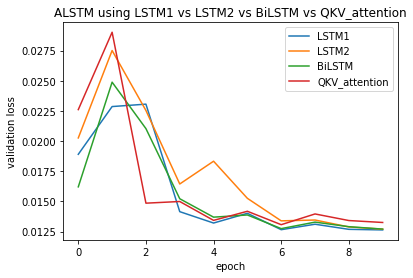

In [ ]:
plt.figure()
plt.plot(history_alstm1.history['val_mae'])
plt.plot(history_alstm2.history['val_mae'])
plt.plot(history_alstm1b.history['val_mae'])
plt.plot(history_alstm_qkv.history['val_mae'])
plt.title('ALSTM using LSTM1 vs LSTM2 vs BiLSTM vs QKV_attention')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(['LSTM1', 'LSTM2', 'BiLSTM', 'QKV_attention'], loc='upper right')
plt.show()

## Bi-Pathway ALSTM using both Weather and Power Features

In [ ]:
def alstm_model_seg(x):
    #x = Input(shape=x[1:])
    lstm_out, hidden, _ = LSTM(100, activation='tanh',\
                            return_sequences=True, return_state=True)(x)
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, lstm_out])
    
    #out = Dense(1,activation='linear')(out)
    return att_out

def bialstm(x1, x2):
    x1 = Input(shape=x1[1:])
    x2 = Input(shape=x2[1:])
    out1 = alstm_model_seg(x1)
    out2 = alstm_model_seg(x2)
    
    out = Dot(axes=(2, 2))([out1, out2])
    #out = Concatenate(axis=-1)([out1, out2])
    out = Dense(1)(out)
    model = Model(inputs=[x1, x2], outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_bialstm = bialstm(Xtrain_power.shape, Xtrain_weather.shape)
model_bialstm.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 15, 22)]     0                                            
__________________________________________________________________________________________________
lstm_47 (LSTM)                  [(None, 15, 100), (N 40800       input_33[0][0]                   
__________________________________________________________________________________________________
lstm_48 (LSTM)                  [(None, 15, 100), (N 49200       input_34[0][0]                   
______________________________________________________________________________________

In [ ]:
history_bialstm = model_bialstm.fit([Xtrain_power, Xtrain_weather], Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0140 - mae: 0.0466 - val_loss: 0.0019 - val_mae: 0.0157
Epoch 2/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0051 - mae: 0.0334 - val_loss: 0.0026 - val_mae: 0.0309
Epoch 3/10
1724/1724 [==============================] - 35s 21ms/step - loss: 0.0050 - mae: 0.0328 - val_loss: 0.0019 - val_mae: 0.0177
Epoch 4/10
1724/1724 [==============================] - 40s 23ms/step - loss: 0.0049 - mae: 0.0308 - val_loss: 0.0018 - val_mae: 0.0146
Epoch 5/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0048 - mae: 0.0298 - val_loss: 0.0020 - val_mae: 0.0189
Epoch 6/10
1724/1724 [==============================] - 37s 22ms/step - loss: 0.0048 - mae: 0.0290 - val_loss: 0.0019 - val_mae: 0.0170
Epoch 7/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0047 - mae: 0.0279 - val_loss: 0.0018 - val_mae: 0.0151
Epoch 8/10
1724/1724 [==========================

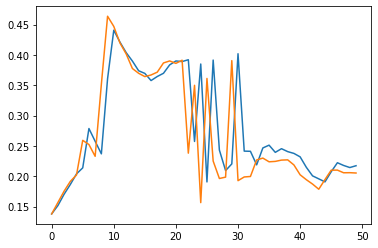

In [ ]:
pred_model_bialstm = model_bialstm.predict([Xtest_power, Xtest_weather])
plt.figure()
plt.plot(pred_model_bialstm[:50])
plt.plot(Ytest_power[:50])
plt.show()

### BiALSTM using Multiplication Merging Method

In [ ]:
def bialstm_mult(x1, x2):
    x1 = Input(shape=x1[1:])
    x2 = Input(shape=x2[1:])
    out1 = alstm_model_seg(x1)
    out2 = alstm_model_seg(x2)
    
    out = Multiply()([out1, out2])
    #out = Concatenate(axis=-1)([out1, out2])
    out = Dense(1)(out)
    model = Model(inputs=[x1, x2], outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_bialstm_m = bialstm_mult(Xtrain_power.shape, Xtrain_weather.shape)
model_bialstm_m.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 15, 22)]     0                                            
__________________________________________________________________________________________________
lstm_49 (LSTM)                  [(None, 15, 100), (N 40800       input_35[0][0]                   
__________________________________________________________________________________________________
lstm_50 (LSTM)                  [(None, 15, 100), (N 49200       input_36[0][0]                   
______________________________________________________________________________________

In [ ]:
history_bialstm_m = model_bialstm_m.fit([Xtrain_power, Xtrain_weather], Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0063 - mae: 0.0384 - val_loss: 0.0019 - val_mae: 0.0175
Epoch 2/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0049 - mae: 0.0317 - val_loss: 0.0021 - val_mae: 0.0237
Epoch 3/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0049 - mae: 0.0315 - val_loss: 0.0020 - val_mae: 0.0222
Epoch 4/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0047 - mae: 0.0294 - val_loss: 0.0018 - val_mae: 0.0160
Epoch 5/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0047 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0139
Epoch 6/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0046 - mae: 0.0273 - val_loss: 0.0018 - val_mae: 0.0136
Epoch 7/10
1724/1724 [==============================] - 35s 21ms/step - loss: 0.0046 - mae: 0.0264 - val_loss: 0.0018 - val_mae: 0.0137
Epoch 8/10
1724/1724 [==========================

### BiALSTM with Concatenation Merging

In [ ]:
def bialstm_concate(x1, x2):
    x1 = Input(shape=x1[1:])
    x2 = Input(shape=x2[1:])
    out1 = alstm_model_seg(x1)
    out2 = alstm_model_seg(x2)
    
    out = Concatenate(axis=-1)([out1, out2])
    out = Dense(1)(out)
    model = Model(inputs=[x1, x2], outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_bialstm_c = bialstm_concate(Xtrain_power.shape, Xtrain_weather.shape)
model_bialstm_c.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 15, 22)]     0                                            
__________________________________________________________________________________________________
lstm_51 (LSTM)                  [(None, 15, 100), (N 40800       input_37[0][0]                   
__________________________________________________________________________________________________
lstm_52 (LSTM)                  [(None, 15, 100), (N 49200       input_38[0][0]                   
______________________________________________________________________________________

In [ ]:
history_bialstm_c = model_bialstm_c.fit([Xtrain_power, Xtrain_weather], Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0105 - mae: 0.0420 - val_loss: 0.0019 - val_mae: 0.0169
Epoch 2/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0050 - mae: 0.0326 - val_loss: 0.0021 - val_mae: 0.0241
Epoch 3/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0049 - mae: 0.0320 - val_loss: 0.0019 - val_mae: 0.0182 - loss: 0.0049 - mae: 0.0 - ETA
Epoch 4/10
1724/1724 [==============================] - 37s 22ms/step - loss: 0.0048 - mae: 0.0300 - val_loss: 0.0018 - val_mae: 0.0166
Epoch 5/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0047 - mae: 0.0289 - val_loss: 0.0018 - val_mae: 0.0147
Epoch 6/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0047 - mae: 0.0280 - val_loss: 0.0018 - val_mae: 0.0138
Epoch 7/10
1724/1724 [==============================] - 40s 23ms/step - loss: 0.0046 - mae: 0.0270 - val_loss: 0.0018 - val_mae: 0.0137
Epoch 8/10
1724/

### BiALSTM with additional LSTM layer

In [ ]:
def alstm_model_seg2(x):
    lstm_out, hidden, _ = LSTM(100, activation='tanh',\
                            return_sequences=True, return_state=True)(x)       
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, lstm_out])

    
    ## Second LSTM
    lstm_out2 = LSTM(100, activation='tanh', return_sequences=False)(att_out)
    return lstm_out2
    
def bialstm2(x1, x2):
    x1 = Input(shape=x1[1:])
    x2 = Input(shape=x2[1:])
    out1 = alstm_model_seg2(x1)
    out2 = alstm_model_seg2(x2)
    
    out = Concatenate(axis=-1)([out1, out2])
    out = Dense(1)(out)
    model = Model(inputs=[x1, x2], outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_bialstm2 = bialstm2(Xtrain_power.shape, Xtrain_weather.shape)
model_bialstm2.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 15, 22)]     0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  [(None, 15, 100), (N 40800       input_39[0][0]                   
__________________________________________________________________________________________________
lstm_55 (LSTM)                  [(None, 15, 100), (N 49200       input_40[0][0]                   
______________________________________________________________________________________

In [ ]:
history_bialstm2 = model_bialstm2.fit([Xtrain_power, Xtrain_weather], Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 54s 31ms/step - loss: 0.0148 - mae: 0.0450 - val_loss: 0.0019 - val_mae: 0.0168
Epoch 2/10
1724/1724 [==============================] - 47s 28ms/step - loss: 0.0050 - mae: 0.0330 - val_loss: 0.0024 - val_mae: 0.0287
Epoch 3/10
1724/1724 [==============================] - 50s 29ms/step - loss: 0.0050 - mae: 0.0330 - val_loss: 0.0025 - val_mae: 0.0316
Epoch 4/10
1724/1724 [==============================] - 50s 29ms/step - loss: 0.0048 - mae: 0.0309 - val_loss: 0.0020 - val_mae: 0.0231
Epoch 5/10
1724/1724 [==============================] - 48s 28ms/step - loss: 0.0047 - mae: 0.0297 - val_loss: 0.0020 - val_mae: 0.0221
Epoch 6/10
1724/1724 [==============================] - 47s 27ms/step - loss: 0.0047 - mae: 0.0288 - val_loss: 0.0018 - val_mae: 0.0159
Epoch 7/10
1724/1724 [==============================] - 51s 30ms/step - loss: 0.0046 - mae: 0.0276 - val_loss: 0.0018 - val_mae: 0.0147
Epoch 8/10
1724/1724 [==========================

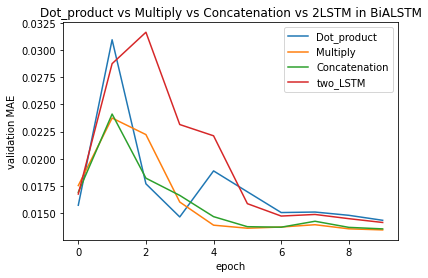

In [ ]:
plt.figure()
plt.plot(history_bialstm.history['val_mae'])
plt.plot(history_bialstm_m.history['val_mae'])
plt.plot(history_bialstm_c.history['val_mae'])
plt.plot(history_bialstm2.history['val_mae'])
plt.title('Dot_product vs Multiply vs Concatenation vs 2LSTM in BiALSTM')
plt.ylabel('validation MAE')
plt.xlabel('epoch')
plt.legend(['Dot_product', 'Multiply', 'Concatenation', 'two_LSTM'], loc='upper right')
plt.show()

### CNN + ALSTM

In [ ]:
def cnn_alstm(x):
    inputs = Input(shape=x[1:])

    conv_out = Conv1D(filters=64, kernel_size=1, activation = 'relu')(inputs)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True))(conv_out)
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, lstm_out])

    out = Dense(1, activation='linear')(att_out)
    model = Model(inputs=inputs, outputs=out[:, -1, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_calstm = cnn_alstm(Xtrain_power.shape)
model_calstm.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 64)       128         input_41[0][0]                   
__________________________________________________________________________________________________
bidirectional_39 (Bidirectional (None, 15, 100)      46000       conv1d[0][0]                     
__________________________________________________________________________________________________
dense_498 (Dense)               (None, 15, 100)      10100       bidirectional_39[0][0]           
______________________________________________________________________________________

In [ ]:
history_calstm = model_calstm.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 32s 19ms/step - loss: 0.0057 - mae: 0.0366 - val_loss: 0.0019 - val_mae: 0.0149
Epoch 2/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.0050 - mae: 0.0332 - val_loss: 0.0021 - val_mae: 0.0232
Epoch 3/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.0050 - mae: 0.0333 - val_loss: 0.0027 - val_mae: 0.0331
Epoch 4/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.0048 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0150
Epoch 5/10
1724/1724 [==============================] - 34s 19ms/step - loss: 0.0047 - mae: 0.0286 - val_loss: 0.0018 - val_mae: 0.0162
Epoch 6/10
1724/1724 [==============================] - 34s 20ms/step - loss: 0.0046 - mae: 0.0276 - val_loss: 0.0018 - val_mae: 0.0137
Epoch 7/10
1724/1724 [==============================] - 34s 19ms/step - loss: 0.0046 - mae: 0.0264 - val_loss: 0.0018 - val_mae: 0.0129
Epoch 8/10
1724/1724 [==========================

In [ ]:
def cnn_alstm_flat(x):
    inputs = Input(shape=x[1:])

    conv_out = Conv1D(filters=64, kernel_size=1, activation = 'relu')(inputs)
    lstm_out = Bidirectional(LSTM(50, return_sequences=True))(conv_out)
    
    ## Scaled Product Attention
    align = Dense(lstm_out.shape[2])(lstm_out)
    score = Activation('tanh')(align)
    score = Dot(axes=(2, 2))([score, lstm_out])/np.sqrt(lstm_out.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, lstm_out])
    
    att_out = Flatten()(att_out)

    out = Dense(1, activation='linear')(att_out)
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_calstm_f = cnn_alstm_flat(Xtrain_power.shape)
model_calstm_f.summary()

Model: "functional_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 64)       128         input_42[0][0]                   
__________________________________________________________________________________________________
bidirectional_40 (Bidirectional (None, 15, 100)      46000       conv1d_1[0][0]                   
__________________________________________________________________________________________________
dense_500 (Dense)               (None, 15, 100)      10100       bidirectional_40[0][0]           
______________________________________________________________________________________

In [ ]:
history_calstm_f = model_calstm_f.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 30s 17ms/step - loss: 0.0078 - mae: 0.0459 - val_loss: 0.0019 - val_mae: 0.0161
Epoch 2/10
1724/1724 [==============================] - 31s 18ms/step - loss: 0.0053 - mae: 0.0368 - val_loss: 0.0022 - val_mae: 0.0267
Epoch 3/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0052 - mae: 0.0359 - val_loss: 0.0019 - val_mae: 0.0185
Epoch 4/10
1724/1724 [==============================] - 39s 22ms/step - loss: 0.0050 - mae: 0.0322 - val_loss: 0.0020 - val_mae: 0.0230
Epoch 5/10
1724/1724 [==============================] - 37s 21ms/step - loss: 0.0049 - mae: 0.0306 - val_loss: 0.0023 - val_mae: 0.0287
Epoch 6/10
1724/1724 [==============================] - 40s 23ms/step - loss: 0.0048 - mae: 0.0293 - val_loss: 0.0018 - val_mae: 0.0138
Epoch 7/10
1724/1724 [==============================] - 39s 22ms/step - loss: 0.0048 - mae: 0.0278 - val_loss: 0.0018 - val_mae: 0.0136
Epoch 8/10
1724/1724 [==========================

## Transformer

In [ ]:
def self_attention(q, k, v, w_dim, n_head=1):
    Q = Dense(w_dim, use_bias=False)(q)
    K = Dense(w_dim, use_bias=False)(k)
    V = Dense(w_dim, use_bias=False)(v)
    
    score = Dot(axes=(2, 2))([Q, K]) / np.sqrt(Q.shape[-1])
    att_weights = Activation('softmax')(score)
    output = Dot(axes=(2, 1))([att_weights, V])
    return output

def feed_forward(x, hidden_dim):
    output = Dense(hidden_dim, activation='relu')(x)
    return output

def model_transformer1(x):
    x = Input(shape=x[1:])
    
    ## Encoder sectoin
    # Self-Attention
    weight_dim = 64
    att_out = self_attention(x, x, x, weight_dim)
    
    # Add + Layer Normalization
    x_ =  Dense(weight_dim, use_bias=False, name='Ext_Encoder')(x)
    norm_out = Add()([x_, att_out])
    norm_out = LayerNormalization()(norm_out)
    
    # Pass the output to the feed forward network 
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add(name='Self_Att_Encoder')([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
    
    decoder_input = expand_dims(x[:, -1, :], axis=1)
    
    #lstm_out2 = Bidirectional(LSTM(50, return_sequences=True))(decoder_input)
    decoder_att = self_attention(decoder_input, decoder_input, decoder_input, weight_dim)
    decoder_input_ =  Dense(decoder_att.shape[-1], use_bias=False)(decoder_input)
    norm_out = Add()([decoder_input_, decoder_att])
    norm_out = LayerNormalization()(norm_out)

    encoder_att = self_attention(norm_out, ffd_out, ffd_out, weight_dim)
    norm_out = Add()([norm_out, encoder_att])
    norm_out = LayerNormalization()(norm_out)
        
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add()([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
        
    out = Dense(decoder_input.shape[-1], use_bias=False)(ffd_out)
    out = Activation('softmax')(out)
    #out = Dense(1)(out[:, 0, :])
    
    model = Model(inputs=x, outputs=out[:, 0, :])
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_t1 = model_transformer1(Xtrain_power.shape)
model_t1.summary()

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
dense_574 (Dense)               (None, 15, 64)       64          input_50[0][0]                   
__________________________________________________________________________________________________
dense_575 (Dense)               (None, 15, 64)       64          input_50[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_44 (T [(None, 1)]          0           input_50[0][0]                   
______________________________________________________________________________________

In [ ]:
history_t1 = model_t1.fit(Xtrain_power, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 33s 19ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 2/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 3/10
1724/1724 [==============================] - 41s 24ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556a - ETA: 2s 
Epoch 4/10
1724/1724 [==============================] - 43s 25ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 5/10
1724/1724 [==============================] - 45s 26ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 6/10
1724/1724 [==============================] - 42s 25ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556s - loss: 0.6033 - mae: 0.738
Epoch 7/10
1724/1724 [==============================] - 44s 26ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 8

### Transformer on Weather

In [ ]:
def model_transformer1_w(x):
    x = Input(shape=x[1:])
    
    ## Encoder sectoin
    # Self-Attention
    weight_dim = 64
    att_out = self_attention(x, x, x, weight_dim)
    
    # Add + Layer Normalization
    x_ =  Dense(weight_dim, use_bias=False, name='Ext_Encoder')(x)
    norm_out = Add()([x_, att_out])
    norm_out = LayerNormalization()(norm_out)
    
    # Pass the output to the feed forward network 
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add(name='Self_Att_Encoder')([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
    
    decoder_input = expand_dims(x[:, -1, :], axis=1)
    
    #lstm_out2 = Bidirectional(LSTM(50, return_sequences=True))(decoder_input)
    decoder_att = self_attention(decoder_input, decoder_input, decoder_input, weight_dim)
    decoder_input_ =  Dense(decoder_att.shape[-1], use_bias=False)(decoder_input)
    norm_out = Add()([decoder_input_, decoder_att])
    norm_out = LayerNormalization()(norm_out)

    encoder_att = self_attention(norm_out, ffd_out, ffd_out, weight_dim)
    norm_out = Add()([norm_out, encoder_att])
    norm_out = LayerNormalization()(norm_out)
        
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add()([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
        
    out = Dense(decoder_input.shape[-1], use_bias=False)(ffd_out)
    out = Activation('softmax')(out)
    out = Dense(1)(out[:, 0, :])
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_t1_w = model_transformer1_w(Xtrain_weather.shape)
model_t1_w.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 15, 22)]     0                                            
__________________________________________________________________________________________________
dense_560 (Dense)               (None, 15, 64)       1408        input_49[0][0]                   
__________________________________________________________________________________________________
dense_561 (Dense)               (None, 15, 64)       1408        input_49[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_42 (T [(None, 22)]         0           input_49[0][0]                   
______________________________________________________________________________________

In [ ]:
history_t1_w = model_t1_w.fit(Xtrain_weather, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.0139 - mae: 0.0796 - val_loss: 0.0106 - val_mae: 0.0639
Epoch 2/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0105 - mae: 0.0642 - val_loss: 0.0069 - val_mae: 0.0521
Epoch 3/10
1724/1724 [==============================] - 35s 20ms/step - loss: 0.0099 - mae: 0.0610 - val_loss: 0.0058 - val_mae: 0.0516
Epoch 4/10
1724/1724 [==============================] - 34s 20ms/step - loss: 0.0092 - mae: 0.0567 - val_loss: 0.0049 - val_mae: 0.0441
Epoch 5/10
1724/1724 [==============================] - 52s 30ms/step - loss: 0.0087 - mae: 0.0539 - val_loss: 0.0049 - val_mae: 0.0426
Epoch 6/10
1724/1724 [==============================] - 39s 23ms/step - loss: 0.0084 - mae: 0.0517 - val_loss: 0.0049 - val_mae: 0.0432
Epoch 7/10
1724/1724 [==============================] - 36s 21ms/step - loss: 0.0081 - mae: 0.0501 - val_loss: 0.0050 - val_mae: 0.0429 0.0081 - mae:
Epoch 8/10
1724/1724 [============

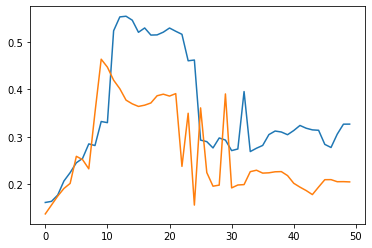

In [ ]:
pred_t1_w = model_t1_w.predict(Xtest_weather)
plt.figure()
plt.plot(pred_t1_w[:50])
plt.plot(Ytest_power[:50])
plt.show()

## Prediction on Test

### Evaluation on Power & Weather

#### LSTM

In [ ]:
model_lstm1_a = lstm_model(Xtrain_all.shape)
model_lstm1_a.summary()

print('-'*30)
print('Fitting additional LSTM layer model...')
print('-'*30)
history_lstm1_a=model_lstm1_a.fit(Xtrain_all, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 15, 23)]          0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 100)               49600     
_________________________________________________________________
dense_599 (Dense)            (None, 1)                 101       
Total params: 49,701
Trainable params: 49,701
Non-trainable params: 0
_________________________________________________________________
------------------------------
Fitting additional LSTM layer model...
------------------------------
Epoch 1/10
1724/1724 [==============================] - 18s 10ms/step - loss: 0.0156 - mae: 0.0413 - val_loss: 0.0019 - val_mae: 0.0162
Epoch 2/10
1724/1724 [==============================] - 18s 11ms/step - loss: 0.0049 - mae: 0.0328 - val_loss: 0.0022 - val_mae: 0.0254
Epoch 

In [ ]:
model_lstm2_a = lstm_model2(Xtrain_all.shape)
model_lstm2_a.summary()

print('-'*30)
print('Fitting additional LSTM layer model...')
print('-'*30)
history_lstm2_a=model_lstm2_a.fit(Xtrain_all, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 15, 23)]          0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 15, 100)           49600     
_________________________________________________________________
dense_595 (Dense)            (None, 15, 23)            2323      
_________________________________________________________________
lstm_68 (LSTM)               (None, 100)               49600     
_________________________________________________________________
dense_596 (Dense)            (None, 1)                 101       
Total params: 101,624
Trainable params: 101,624
Non-trainable params: 0
_________________________________________________________________
------------------------------
Fitting additional LSTM layer model...
------------------------------
Epoch 1/10
1

#### ALSTM

In [ ]:
model_alstm1_a = alstm_model1(Xtrain_all.shape)
model_alstm1_a.summary()

print('-'*30)
print('Fitting ALSTM with LSTM*1 model...')
print('-'*30)
history_alstm1_a=model_alstm1_a.fit(Xtrain_all, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

Model: "functional_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 15, 23)]     0                                            
__________________________________________________________________________________________________
lstm_69 (LSTM)                  [(None, 15, 100), (N 49600       input_57[0][0]                   
__________________________________________________________________________________________________
dense_597 (Dense)               (None, 15, 100)      10100       lstm_69[0][0]                    
__________________________________________________________________________________________________
activation_311 (Activation)     (None, 15, 100)      0           dense_597[0][0]                  
______________________________________________________________________________________

#### CNN+ALSTM

In [ ]:
model_calstm_a = cnn_alstm(Xtrain_all.shape)
model_calstm_a.summary()

print('-'*30)
print('Fitting CNN + ALSTM model...')
print('-'*30)
history_calstm_a=model_calstm_a.fit(Xtrain_all, Ytrain_power, validation_split=0.2,\
                    callbacks=my_cb, batch_size=batch_size, epochs=epoch ,verbose=1)

Model: "functional_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 15, 23)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 15, 64)       1536        input_59[0][0]                   
__________________________________________________________________________________________________
bidirectional_46 (Bidirectional (None, 15, 100)      46000       conv1d_3[0][0]                   
__________________________________________________________________________________________________
dense_600 (Dense)               (None, 15, 100)      10100       bidirectional_46[0][0]           
______________________________________________________________________________________

#### Transformer

In [ ]:
model_t1_a = model_transformer1_w(Xtrain_all.shape)
model_t1_a.summary()

history_t1_a = model_t1_a.fit(Xtrain_all, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 15, 23)]     0                                            
__________________________________________________________________________________________________
dense_602 (Dense)               (None, 15, 64)       1472        input_60[0][0]                   
__________________________________________________________________________________________________
dense_603 (Dense)               (None, 15, 64)       1472        input_60[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_49 (T [(None, 23)]         0           input_60[0][0]                   
______________________________________________________________________________________

Epoch 1/10
1724/1724 [==============================] - 43s 25ms/step - loss: 0.0062 - mae: 0.0420 - val_loss: 0.0022 - val_mae: 0.0226
Epoch 2/10
1724/1724 [==============================] - 47s 27ms/step - loss: 0.0050 - mae: 0.0352 - val_loss: 0.0026 - val_mae: 0.0301
Epoch 3/10
1724/1724 [==============================] - 56s 32ms/step - loss: 0.0050 - mae: 0.0342 - val_loss: 0.0028 - val_mae: 0.0347
Epoch 4/10
1724/1724 [==============================] - 64s 37ms/step - loss: 0.0048 - mae: 0.0318 - val_loss: 0.0019 - val_mae: 0.0175
Epoch 5/10
1724/1724 [==============================] - 62s 36ms/step - loss: 0.0047 - mae: 0.0303 - val_loss: 0.0020 - val_mae: 0.0209
Epoch 6/10
1724/1724 [==============================] - 54s 31ms/step - loss: 0.0047 - mae: 0.0292 - val_loss: 0.0019 - val_mae: 0.0164
Epoch 7/10
1724/1724 [==============================] - 42s 24ms/step - loss: 0.0046 - mae: 0.0280 - val_loss: 0.0019 - val_mae: 0.0160ETA: 0s - loss: 0.0046 - mae: 0.028 - ETA: 0s - l

In [ ]:
pred_lstm1 = model_lstm1_a.predict(Xtest_all)
pred_alstm1 = model_alstm1_a.predict(Xtest_all)
pred_calstm = model_calstm_a.predict(Xtest_all)
pred_trans = model_t1_a.predict(Xtest_all)
pred_bialstm = model_bialstm_m.predict([Xtest_power, Xtest_weather])

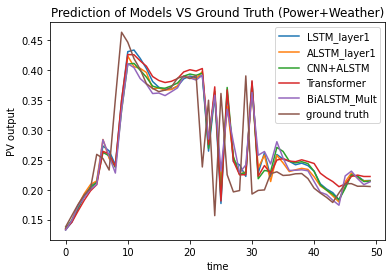

In [ ]:
plt.figure()
plt.plot(pred_lstm1[:50])
plt.plot(pred_alstm1[:50])
plt.plot(pred_calstm[:50])
plt.plot(pred_trans[:50])
plt.plot(pred_bialstm[:50])
plt.plot(Ytest_power[:50])
plt.title('Prediction of Models VS Ground Truth (Power+Weather)')
plt.ylabel('PV output')
plt.xlabel('time')
plt.legend(['LSTM_layer1', \
            'ALSTM_layer1',\
            'CNN+ALSTM', \
            'Transformer',\
            'BiALSTM_Mult', 'ground truth'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def evaluation(model, Xtest, Ytest):
    pred = model.predict(Xtest)
    pred = scaler1.inverse_transform(pred)
    gt = scaler1.inverse_transform(Ytest)
    mse = rmse(pred, gt)
    mae = mean_absolute_error(pred, gt)
    print('Test Data RMSE: {0:.3f}'.format(mse))
    print('Test Data MAE: {0:.3f}'.format(mae))
    return mse, mae

In [ ]:
model_list = {'lstm1':model_lstm1_a, 'alstm1':model_alstm1_a,\
              'calstm':model_calstm_a, 'trans':model_t1_a}
mse_list = [44.65]
mae_list = [27.08]

for model in model_list:
    print(model)
    mse, mae = evaluation(model_list[model], Xtest_all, Ytest_power)
    mse_list.append(round(mse/1000, 2))
    mae_list.append(round(mae/1000, 2))
    
print('ClusterLSTM')
mse_list.append(round(35524.634/1000, 2))
mae_list.append(round(17624.241/1000, 2))
print('bialstm')
mse, mae = evaluation(model_bialstm_m, [Xtest_power, Xtest_weather], Ytest_power)
mse_list.append(round(mse/1000, 2))
mae_list.append(round(mae/1000, 2))

lstm1
Test Data RMSE: 34797.333
Test Data MAE: 16060.086
alstm1
Test Data RMSE: 34643.855
Test Data MAE: 16001.605
calstm
Test Data RMSE: 34617.788
Test Data MAE: 16543.563
trans
Test Data RMSE: 35385.812
Test Data MAE: 17334.691
ClusterLSTM
bialstm
Test Data RMSE: 34049.819
Test Data MAE: 15758.227


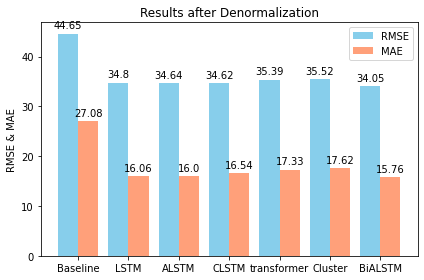

In [ ]:
labels = ['Baseline', 'LSTM', 'ALSTM', 'CLSTM', 'transformer', 'Cluster', 'BiALSTM']

x = np.arange(len(labels))
width = 0.4 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_list, width, color='skyblue', label='RMSE')
rects2 = ax.bar(x + width/2, mae_list, width, color='lightsalmon', label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE & MAE')
ax.set_title('Results after Denormalization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Evalutation on Test Power

In [ ]:
pred_lstm1 = model_lstm1.predict(Xtest_power)
pred_alstm1 = model_alstm1.predict(Xtest_power)
pred_calstm = model_calstm.predict(Xtest_power)
pred_t1_p = model_t1.predict(Xtest_power)
pred_bialstm = model_bialstm.predict([Xtest_power, Xtest_weather])

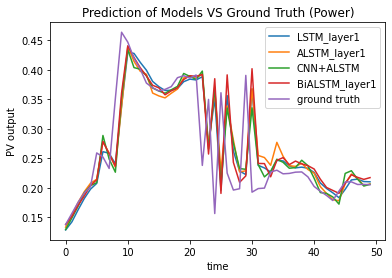

In [ ]:
plt.figure()
plt.plot(pred_lstm1[:50])
plt.plot(pred_alstm1[:50])
plt.plot(pred_calstm[:50])
#plt.plot(pred_alstm2)
plt.plot(pred_bialstm[:50])
plt.plot(Ytest_power[:50])
plt.title('Prediction of Models VS Ground Truth (Power)')
plt.ylabel('PV output')
plt.xlabel('time')
plt.legend(['LSTM_layer1', \
            'ALSTM_layer1',\
            'CNN+ALSTM', 'BiALSTM_layer1', 'ground truth'], loc='upper right')
plt.show()

In [ ]:
model_list = {'lstm1':model_lstm1, 'alstm1':model_alstm1,\
              'calstm':model_calstm, 'trans':model_t1}
mse_list = []
mae_list = []

for model in model_list:
    print(model)
    mse, mae = evaluation(model_list[model], Xtest_power, Ytest_power)
    mse_list.append(round(mse/1000, 2))
    mae_list.append(round(mae/1000, 2))
    
    
print('bialstm')
mse, mae = evaluation(model_bialstm, [Xtest_power, Xtest_weather], Ytest_power)
mse_list.append(round(mse/1000, 2))
mae_list.append(round(mae/1000, 2))

lstm1
Test Data RMSE: 34233.050
Test Data MAE: 15680.356
alstm1
Test Data RMSE: 33720.018
Test Data MAE: 15096.805
calstm
Test Data RMSE: 33516.661
Test Data MAE: 15015.294
trans
Test Data RMSE: 271935.922
Test Data MAE: 253197.894
bialstm
Test Data RMSE: 34452.636
Test Data MAE: 16146.558


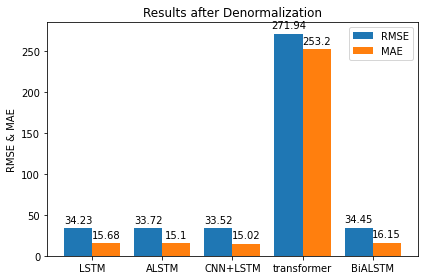

In [ ]:
labels = ['LSTM', 'ALSTM', 'CNN+LSTM', 'transformer', 'BiALSTM']

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_list, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_list, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE & MAE')
ax.set_title('Results after Denormalization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Prediction on Weather Features

In [ ]:
model_alstm1_w = alstm_model1(Xtrain_weather.shape)
history_alstm1_w = model_alstm1_w.fit(Xtrain_weather, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 30s 17ms/step - loss: 0.0173 - mae: 0.0855 - val_loss: 0.0092 - val_mae: 0.0580
Epoch 2/10
1724/1724 [==============================] - 28s 16ms/step - loss: 0.0106 - mae: 0.0655 - val_loss: 0.0076 - val_mae: 0.0624
Epoch 3/10
1724/1724 [==============================] - 28s 16ms/step - loss: 0.0097 - mae: 0.0605 - val_loss: 0.0058 - val_mae: 0.0505
Epoch 4/10
1724/1724 [==============================] - 28s 16ms/step - loss: 0.0089 - mae: 0.0557 - val_loss: 0.0048 - val_mae: 0.0414
Epoch 5/10
1724/1724 [==============================] - 29s 17ms/step - loss: 0.0084 - mae: 0.0524 - val_loss: 0.0048 - val_mae: 0.0408
Epoch 6/10
1724/1724 [==============================] - 28s 16ms/step - loss: 0.0081 - mae: 0.0500 - val_loss: 0.0048 - val_mae: 0.0424 loss: 0.0081 - mae: 0.0
Epoch 7/10
1724/1724 [==============================] - 28s 16ms/step - loss: 0.0078 - mae: 0.0479 - val_loss: 0.0052 - val_mae: 0.0447
Epoch 8/10
1724/1724 [==

In [ ]:
model_calstm_w = cnn_alstm(Xtrain_weather.shape)
history_calstm_w = model_calstm_w.fit(Xtrain_weather, Ytrain_power, validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 42s 24ms/step - loss: 0.0212 - mae: 0.0966 - val_loss: 0.0130 - val_mae: 0.0744
Epoch 2/10
1724/1724 [==============================] - 39s 23ms/step - loss: 0.0137 - mae: 0.0805 - val_loss: 0.0094 - val_mae: 0.0689s - loss: 0.
Epoch 3/10
1724/1724 [==============================] - 40s 23ms/step - loss: 0.0116 - mae: 0.0700 - val_loss: 0.0071 - val_mae: 0.0565
Epoch 4/10
1724/1724 [==============================] - 42s 24ms/step - loss: 0.0104 - mae: 0.0631 - val_loss: 0.0049 - val_mae: 0.0434
Epoch 5/10
1724/1724 [==============================] - 38s 22ms/step - loss: 0.0098 - mae: 0.0598 - val_loss: 0.0057 - val_mae: 0.0476
Epoch 6/10
1724/1724 [==============================] - 40s 23ms/step - loss: 0.0094 - mae: 0.0575 - val_loss: 0.0048 - val_mae: 0.0423
Epoch 7/10
1724/1724 [==============================] - 41s 24ms/step - loss: 0.0091 - mae: 0.0554 - val_loss: 0.0052 - val_mae: 0.0435
Epoch 8/10
1724/1724 [==============

In [ ]:
pred_lstm1_w = model_lstm_w.predict(Xtest_weather)
pred_alstm1_w = model_alstm1_w.predict(Xtest_weather)
pred_calstm_w = model_calstm_w.predict(Xtest_weather)
pred_bialstm_w = model_bialstm_m.predict([Xtest_power, Xtest_weather])
pred_t1_w = model_t1_w.predict(Xtest_weather)

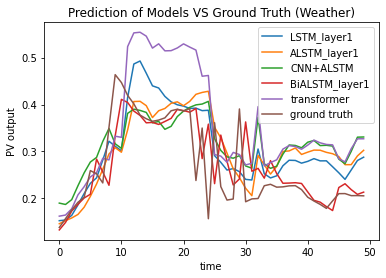

In [ ]:
plt.figure()
plt.plot(pred_lstm1_w[:50])
plt.plot(pred_alstm1_w[:50])
plt.plot(pred_calstm_w[:50])
plt.plot(pred_bialstm_w[:50])
plt.plot(pred_t1_w[:50])
plt.plot(Ytest_power[:50])
plt.title('Prediction of Models VS Ground Truth (Weather)')
plt.ylabel('PV output')
plt.xlabel('time')
plt.legend(['LSTM_layer1', \
            'ALSTM_layer1', \
            'CNN+ALSTM',\
            'BiALSTM_layer1',\
            'transformer',
            'ground truth'], loc='upper right')
plt.show()

In [ ]:
def evaluation(model, Xtest, Ytest):
    pred = model.predict(Xtest)
    pred = scaler1.inverse_transform(pred)
    gt = scaler1.inverse_transform(Ytest)
    mse = rmse(pred, gt)
    mae = mean_absolute_error(pred, gt)
    print('Test Data RMSE: {0:.3f}'.format(mse))
    print('Test Data MAE: {0:.3f}'.format(mae))
    return mse, mae


model_list = {'lstm1':model_lstm_w, 'alstm1':model_alstm1_w,\
              'calstm':model_calstm_w, 'trans':model_t1_w}
mse_list_w = []
mae_list_w = []

for model in model_list:
    print(model)
    mse, mae = evaluation(model_list[model], Xtest_weather, Ytest_power)
    mse_list_w.append(round(mse/1000, 2))
    mae_list_w.append(round(mae/1000, 2))
    
    
print('bialstm')
mse, mae = evaluation(model_bialstm, [Xtest_power, Xtest_weather], Ytest_power)
mse_list_w.append(round(mse/1000, 2))
mae_list_w.append(round(mae/1000, 2))

lstm1
Test Data RMSE: 52196.419
Test Data MAE: 31405.112
alstm1
Test Data RMSE: 53452.488
Test Data MAE: 32591.675
calstm
Test Data RMSE: 58091.840
Test Data MAE: 35710.819
trans
Test Data RMSE: 59439.529
Test Data MAE: 36472.701
bialstm
Test Data RMSE: 34452.636
Test Data MAE: 16146.558


In [ ]:
mae_list_w

[31.41, 32.59, 35.71, 36.47, 16.15]

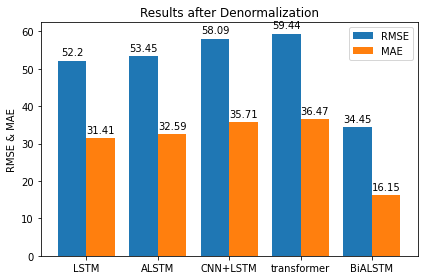

In [ ]:
labels = ['LSTM', 'ALSTM', 'CNN+LSTM', 'transformer', 'BiALSTM']

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse_list_w, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_list_w, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE & MAE')
ax.set_title('Results after Denormalization')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Problem using Power Only vs Weather vs All

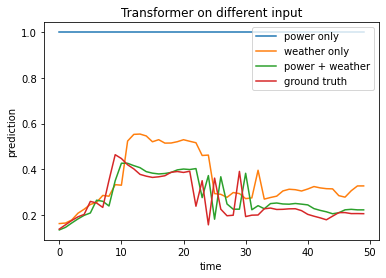

In [ ]:
plt.figure()
plt.plot(pred_t1_p[:50])
plt.plot(pred_t1_w[:50])
plt.plot(pred_trans[:50])
plt.plot(Ytest_power[:50])
plt.title('Transformer on different input')
plt.ylabel('prediction')
plt.xlabel('time')
plt.legend(['power only', \
            'weather only',\
            'power + weather',\
            'ground truth'], loc='upper right')

plt.show()

#### Seq2Seq Transformer

In [ ]:
def self_attention(q, k, v, w_dim, n_head=1):
    Q = Dense(w_dim, use_bias=False)(q)
    K = Dense(w_dim, use_bias=False)(k)
    V = Dense(w_dim, use_bias=False)(v)
    
    score = Dot(axes=(2, 2))([Q, K]) / np.sqrt(Q.shape[-1])
    att_weights = Activation('softmax')(score)
    output = Dot(axes=(2, 1))([att_weights, V])
    return output

def feed_forward(x, hidden_dim):
    output = Dense(hidden_dim, activation='relu')(x)
    return output

def model_transformer(x):
    x = Input(shape=x[1:])
    
    ## Encoder sectoin
    # Self-Attention
    weight_dim = 64
    att_out = self_attention(x, x, x, weight_dim)
    
    # Add + Layer Normalization
    x_ =  Dense(weight_dim, use_bias=False, name='Ext_Encoder')(x)
    norm_out = Add()([x_, att_out])
    norm_out = LayerNormalization()(norm_out)
    
    # Pass the output to the feed forward network 
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add(name='Self_Att_Encoder')([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
    
    decoder_input = expand_dims(x[:, -1, :], axis=1)
    #print(decoder_input.shape)
    #out_seq = K.variable(value=K.zeros(x.shape[1:]))
    out_seq = []
    #print(out_seq.shape)
    for i in range(x.shape[1]):
        decoder_att = self_attention(decoder_input, decoder_input, decoder_input, weight_dim)
        decoder_input_ =  Dense(weight_dim, use_bias=False)(decoder_input)
        norm_out = Add()([decoder_input_, decoder_att])
        norm_out = LayerNormalization()(norm_out)
    
        encoder_att = self_attention(norm_out, ffd_out, ffd_out, weight_dim)
        norm_out = Add()([norm_out, encoder_att])
        norm_out = LayerNormalization()(norm_out)
    
        ffd_out = feed_forward(norm_out, norm_out.shape[-1])
        ffd_out = Add()([norm_out, ffd_out])
        ffd_out = LayerNormalization()(ffd_out)
    
        decoder_input = Dense(decoder_input.shape[-1], use_bias=False)(ffd_out)
        decoder_input = Activation('softmax')(decoder_input)
        
        out_seq.append(decoder_input)
        
    #out = tf.stack(out_seq)
    #out = Reshape((-1, out.shape[0], out.shape[-1]))(out)
    out = Concatenate(axis=1)(out_seq)
    
    out = Dense(1, use_bias=False)(out)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_t = model_transformer(Xtrain_all.shape)
model_t.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 23)]     0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 15, 64)       1472        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 15, 64)       1472        input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 23)]         0           input_2[0][0]                    
_______________________________________________________________________________________

dense_61 (Dense)                (None, 1, 64)        1472        activation_19[0][0]              
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 1, 64)        1472        activation_19[0][0]              
__________________________________________________________________________________________________
dot_28 (Dot)                    (None, 1, 1)         0           dense_61[0][0]                   
                                                                 dense_62[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_RealDiv_14 (TensorF [(None, 1, 1)]       0           dot_28[0][0]                     
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 1, 1)         0           tf_op_layer_RealDiv_14[0][0]     
__________

tf_op_layer_RealDiv_26 (TensorF [(None, 1, 1)]       0           dot_52[0][0]                     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 1, 1)         0           tf_op_layer_RealDiv_26[0][0]     
__________________________________________________________________________________________________
dense_117 (Dense)               (None, 1, 64)        1472        activation_37[0][0]              
__________________________________________________________________________________________________
dense_118 (Dense)               (None, 1, 64)        1472        activation_37[0][0]              
__________________________________________________________________________________________________
dot_53 (Dot)                    (None, 1, 64)        0           activation_38[0][0]              
                                                                 dense_117[0][0]                  
__________

In [ ]:
history_t = model_t.fit(Xtrain_all[:-time_window], Xtrain_power[time_window:], validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=5, verbose=1)

Epoch 1/5
1724/1724 [==============================] - 261s 151ms/step - loss: 0.0518 - mae: 0.1914 - val_loss: 0.0552 - val_mae: 0.2136
Epoch 2/5
1724/1724 [==============================] - 244s 141ms/step - loss: 0.0586 - mae: 0.2089 - val_loss: 0.0552 - val_mae: 0.2134
Epoch 3/5
1724/1724 [==============================] - 260s 151ms/step - loss: 0.0586 - mae: 0.2089 - val_loss: 0.0547 - val_mae: 0.2115
Epoch 4/5
1724/1724 [==============================] - 276s 160ms/step - loss: 0.0585 - mae: 0.2089 - val_loss: 0.0550 - val_mae: 0.2129
Epoch 5/5
1724/1724 [==============================] - 280s 163ms/step - loss: 0.0585 - mae: 0.2089 - val_loss: 0.0548 - val_mae: 0.2119


In [ ]:
Xtrain_power.shape

(551502, 15, 1)

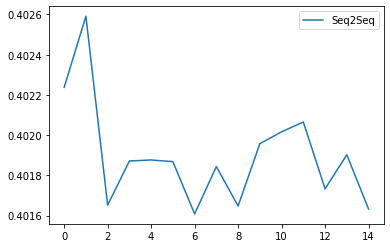

In [ ]:
pred_s2s = model_t.predict([Xtest_all[:50]])
plt.figure()
plt.plot(pred_s2s[0])
#plt.plot(Ytest_power[:15])
plt.legend(['Seq2Seq', \
            'ground truth'], loc='upper right')
plt.show()

In [ ]:
Xtest_power.shape

(61264, 15, 1)

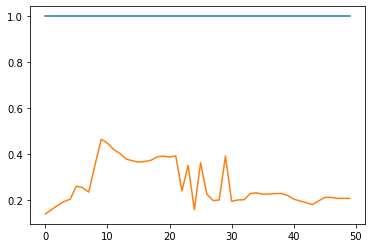

In [ ]:
pred_model_t1 = model_t1.predict(Xtest_power[:50])
plt.figure()
plt.plot(pred_model_t1[:50])
plt.plot(Ytest_power[:50])
plt.show()

In [ ]:
'''
def self_attention(q, k, n_head=1):
    ## QKV method (not help)

    Q = Dense(w_dim, use_bias=False)(q)
    K = Dense(w_dim, use_bias=False)(k)
    V = Dense(w_dim, use_bias=False)(v)
    
    score = Dot(axes=(2, 2))([Q, K]) / np.sqrt(Q.shape[-1])
    att_weights = Activation('softmax')(score)
    output = Dot(axes=(2, 1))([att_weights, V])

    
    ## Scaled Product Attention
    Q = Dense(k.shape[2])(q)
    score = Activation('tanh')(Q)
    score = Dot(axes=(2, 2))([score, k])/np.sqrt(q.shape[-1])
    weights = Activation('softmax')(score)
    att_out = Dot(axes=(2, 1))([weights, k])
    return att_out
        

def feed_forward(x, hidden_dim):
    output = Dense(hidden_dim, activation='relu')(x)
    return output

def Transformer(x):
    x = Input(shape=x[1:])
    
    lstm_out = Bidirectional(LSTM(50, return_sequences=True))(x)
    
    ## Encoder sectoin
    # Self-Attention
    #weight_dim = 64
    att_out = self_attention(lstm_out, lstm_out)
    
    # Add + Layer Normalization
    x_ =  Dense(att_out.shape[-1], use_bias=False, name='Ext_Encoder')(x)
    norm_out = Add(name='Self_Att_Encoder')([x_, att_out])
    norm_out = LayerNormalization()(norm_out)
    
    # Pass the output to the feed forward network 
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add(name='FFD_Add')([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
    
    ## Now continue to Decoders
    decoder_input = expand_dims(x[:, -1, :], axis=1)
    #print(decoder_input.shape)
    #out_seq = K.variable(value=K.zeros(x.shape[1:]))
    out_seq = []
    #print(out_seq.shape)
    for i in range(x.shape[1]):
        lstm_out2 = Bidirectional(LSTM(50, return_sequences=True))(decoder_input)
        decoder_att = self_attention(lstm_out2, lstm_out2)
        decoder_input_ =  Dense(decoder_att.shape[-1], use_bias=False)(decoder_input)
        norm_out = Add()([decoder_input_, decoder_att])
        norm_out = LayerNormalization()(norm_out)

        encoder_att = self_attention(norm_out, ffd_out)
        norm_out = Add()([norm_out, encoder_att])
        norm_out = LayerNormalization()(norm_out)
        
        ffd_out = feed_forward(norm_out, norm_out.shape[-1])
        ffd_out = Add()([norm_out, ffd_out])
        ffd_out = LayerNormalization()(ffd_out)
        
        decoder_input = Dense(decoder_input.shape[-1], use_bias=False)(ffd_out)
        decoder_input = Activation('softmax')(decoder_input)
        
        out_seq.append(decoder_input)
        
    #out = tf.stack(out_seq)
    #out = Reshape((-1, out.shape[0], out.shape[-1]))(out)
    out = Concatenate(axis=1)(out_seq)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_transformer = Transformer(Xtrain_power.shape)
model_transformer.summary()
'''

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_9 (Te [(None, 1)]          0           input_14[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_9 (Tenso [(None, 1, 1)]       0           tf_op_layer_strided_slice_9[0][0]
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 15, 100)      20800       input_14[0][0]                   
_______________________________________________________________________________________

add_84 (Add)                    (None, 1, 100)       0           layer_normalization_101[0][0]    
                                                                 dense_249[0][0]                  
__________________________________________________________________________________________________
layer_normalization_102 (LayerN (None, 1, 100)       200         add_84[0][0]                     
__________________________________________________________________________________________________
dense_250 (Dense)               (None, 1, 1)         100         layer_normalization_102[0][0]    
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 1, 1)         0           dense_250[0][0]                  
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional (None, 1, 100)       20800       activation_145[0][0]             
__________

In [ ]:
#history_transformer = model_transformer.fit(Xtrain_power[:-time_window], Xtrain_power[time_window:], validation_split=0.2,\
#                                batch_size=batch_size, callbacks=my_cb, epochs=epoch, verbose=1)

Epoch 1/10
1724/1724 [==============================] - 380s 220ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 2/10
1724/1724 [==============================] - 425s 247ms/step - loss: 0.6033 - mae: 0.7381 - val_loss: 0.6253 - val_mae: 0.7556
Epoch 3/10
 253/1724 [===>..........................] - ETA: 5:15 - loss: 0.6009 - mae: 0.7365

KeyboardInterrupt: 

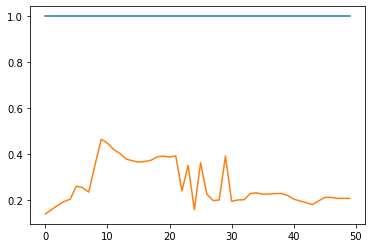

In [ ]:
pred_s2p = model_transformer1.predict([Xtest_power[:50]])
plt.figure()
plt.plot(pred_s2p)
plt.plot(Ytest_power[:50])
plt.show()

In [ ]:
def self_attention(q, k, v, w_dim, n_head=1):
    Q = Dense(w_dim, use_bias=False)(q)
    K = Dense(w_dim, use_bias=False)(k)
    V = Dense(w_dim, use_bias=False)(v)
    
    score = Dot(axes=(2, 2))([Q, K]) / np.sqrt(Q.shape[-1])
    att_weights = Activation('softmax')(score)
    output = Dot(axes=(2, 1))([att_weights, V])
    return output

def model_test(x):
    x = Input(shape=x[1:])
    
    ## Encoder sectoin
    # Self-Attention
    weight_dim = 64
    att_out = self_attention(x, x, x, weight_dim)
    
    # Add + Layer Normalization
    x_ =  Dense(weight_dim, use_bias=False, name='Ext_Encoder')(x)
    norm_out = Add()([x_, att_out])
    norm_out = LayerNormalization()(norm_out)
    
    # Pass the output to the feed forward network 
    ffd_out = feed_forward(norm_out, norm_out.shape[-1])
    ffd_out = Add(name='Self_Att_Encoder')([norm_out, ffd_out])
    ffd_out = LayerNormalization()(ffd_out)
    
    decoder_input = expand_dims(x[:, -1, :], axis=1)
    #print(decoder_input.shape)
    #out_seq = K.variable(value=K.zeros(x.shape[1:]))
    out_seq = []
    #print(out_seq.shape)
    for i in range(x.shape[1]):
        decoder_att = self_attention(decoder_input, decoder_input, decoder_input, weight_dim)
        decoder_input_ =  Dense(weight_dim, use_bias=False)(decoder_input)
        norm_out = Add()([decoder_input_, decoder_att])
        norm_out = LayerNormalization()(norm_out)
    
        encoder_att = self_attention(norm_out, ffd_out, ffd_out, weight_dim)
        norm_out = Add()([norm_out, encoder_att])
        norm_out = LayerNormalization()(norm_out)
    
        ffd_out = feed_forward(norm_out, norm_out.shape[-1])
        ffd_out = Add()([norm_out, ffd_out])
        ffd_out = LayerNormalization()(ffd_out)
    
        decoder_input = Dense(decoder_input.shape[-1], use_bias=False)(ffd_out)
        decoder_input = Activation('softmax')(decoder_input)
        
        out_seq.append(decoder_input)
        
    #out = tf.stack(out_seq)
    #out = Reshape((-1, out.shape[0], out.shape[-1]))(out)
    out = Concatenate(axis=1)(out_seq)
    
    out = Dense(x.shape[-1], use_bias=False)(out)
    
    model = Model(inputs=x, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.015), loss="mse",metrics=['mae'])
    return model

model_t = model_test(Xtrain_power.shape)
model_t.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
dense_319 (Dense)               (None, 15, 64)       64          input_22[0][0]                   
__________________________________________________________________________________________________
dense_320 (Dense)               (None, 15, 64)       64          input_22[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_19 (T [(None, 1)]          0           input_22[0][0]                   
______________________________________________________________________________________

__________________________________________________________________________________________________
layer_normalization_164 (LayerN (None, 1, 64)        128         add_132[0][0]                    
__________________________________________________________________________________________________
dense_376 (Dense)               (None, 1, 1)         64          layer_normalization_164[0][0]    
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 1, 1)         0           dense_376[0][0]                  
__________________________________________________________________________________________________
dense_377 (Dense)               (None, 1, 64)        64          activation_224[0][0]             
__________________________________________________________________________________________________
dense_378 (Dense)               (None, 1, 64)        64          activation_224[0][0]             
__________

tf_op_layer_RealDiv_131 (Tensor [(None, 1, 1)]       0           dot_260[0][0]                    
__________________________________________________________________________________________________
activation_244 (Activation)     (None, 1, 1)         0           tf_op_layer_RealDiv_131[0][0]    
__________________________________________________________________________________________________
dense_437 (Dense)               (None, 1, 64)        4096        layer_normalization_182[0][0]    
__________________________________________________________________________________________________
dot_261 (Dot)                   (None, 1, 64)        0           activation_244[0][0]             
                                                                 dense_437[0][0]                  
__________________________________________________________________________________________________
add_152 (Add)                   (None, 1, 64)        0           layer_normalization_183[0][0]    
          

In [ ]:
history_transformer_t = model_t.fit(Xtrain_power[:-time_window], Xtrain_power[time_window:], validation_split=0.2,\
                                batch_size=batch_size, callbacks=my_cb, epochs=5, verbose=1)

Epoch 1/5
1724/1724 [==============================] - 248s 144ms/step - loss: 0.0727 - mae: 0.2233 - val_loss: 0.0548 - val_mae: 0.2120
Epoch 2/5
1724/1724 [==============================] - 247s 143ms/step - loss: 0.0585 - mae: 0.2089 - val_loss: 0.0546 - val_mae: 0.2113
Epoch 3/5
1724/1724 [==============================] - 246s 142ms/step - loss: 0.0586 - mae: 0.2089 - val_loss: 0.0547 - val_mae: 0.2116
Epoch 4/5
1724/1724 [==============================] - 234s 136ms/step - loss: 0.0585 - mae: 0.2089 - val_loss: 0.0550 - val_mae: 0.2129
Epoch 5/5
1724/1724 [==============================] - 246s 143ms/step - loss: 0.0585 - mae: 0.2089 - val_loss: 0.0548 - val_mae: 0.2119


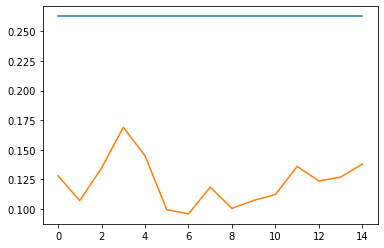

In [ ]:
pred_s2s = model_t.predict([Xtest_power[:50]])
plt.figure()
plt.plot(pred_s2s[0])
plt.plot(Xtest_power[1])
plt.show()

In [ ]:
pred_s2s.shape

(50, 15, 1)

In [ ]:

'''
def model_pred(model, Xtrain, Xtest, scaler):    
    testPred = model.predict(Xtest)
    dummy = pd.DataFrame(np.zeros((len(testPred), n_feature)))
    dummy[0] = testPred
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns) 
    test_trans = dummy[0].values
    test_trans=test_trans.reshape(-1,1)


    trainPred = model.predict(Xtrain_in)
    dummy2 = pd.DataFrame(np.zeros((len(trainPred), n_feature)))
    dummy2[0] = trainPred
    dummy2 = pd.DataFrame(scaler.inverse_transform(dummy2), columns=dummy2.columns) 
    train_trans = dummy2[0].values
    train_trans=train_trans.reshape(-1,1)

    # Calculating train score on invers transformed data
    trainScore_not_scaled = rmse(Ytrain_not_scaled,train_trans)
    print('Training Data RMSE: {0:.3f}'.format(trainScore_not_scaled))
    trainScore_not_scaled_mae = ms.mean_absolute_error(Ytrain_not_scaled,train_trans)
    print('Training Data MAE: {0:.3f}'.format(trainScore_not_scaled_mae))

    # Calculating test score on invers transformed data
    testScore_not_scaled =rmse(Ytest_not_scaled,test_trans)
    print('Test Data RMSE: {0:.3f}'.format(testScore_not_scaled))
    testScore_not_scaled_mae =ms.mean_absolute_error(Ytest_not_scaled,test_trans)
    print('Test Data MAE: {0:.3f}'.format(testScore_not_scaled_mae))
    return train_trans,test_trans
'''

In [ ]:
pred_s2s = model_t.predict([Xtest_power[:50]])
plt.figure()
plt.plot(pred_s2s[0])
plt.plot(Xtest_power[1])
plt.show()

[[[0.00182133]
  [0.00248605]
  [0.0026057 ]
  [0.00315077]
  [0.00397502]
  [0.00478597]
  [0.00612871]
  [0.00667377]
  [0.00695296]
  [0.00816274]
  [0.00949218]
  [0.00990431]
  [0.01112739]
  [0.01247012]
  [0.0139458 ]]

 [[0.00248605]
  [0.0026057 ]
  [0.00315077]
  [0.00397502]
  [0.00478597]
  [0.00612871]
  [0.00667377]
  [0.00695296]
  [0.00816274]
  [0.00949218]
  [0.00990431]
  [0.01112739]
  [0.01247012]
  [0.0139458 ]
  [0.01570065]]

 [[0.0026057 ]
  [0.00315077]
  [0.00397502]
  [0.00478597]
  [0.00612871]
  [0.00667377]
  [0.00695296]
  [0.00816274]
  [0.00949218]
  [0.00990431]
  [0.01112739]
  [0.01247012]
  [0.0139458 ]
  [0.01570065]
  [0.01786764]]

 [[0.00315077]
  [0.00397502]
  [0.00478597]
  [0.00612871]
  [0.00667377]
  [0.00695296]
  [0.00816274]
  [0.00949218]
  [0.00990431]
  [0.01112739]
  [0.01247012]
  [0.0139458 ]
  [0.01570065]
  [0.01786764]
  [0.01934331]]

 [[0.00397502]
  [0.00478597]
  [0.00612871]
  [0.00667377]
  [0.00695296]
  [0.00816274]
  

In [ ]:
a = Xtrain_power[n]
pred = model_transformer.predict(a)
print(a)
print(pred)

[[0.00182133]
 [0.00248605]
 [0.0026057 ]
 [0.00315077]
 [0.00397502]
 [0.00478597]
 [0.00612871]
 [0.00667377]
 [0.00695296]
 [0.00816274]
 [0.00949218]
 [0.00990431]
 [0.01112739]
 [0.01247012]
 [0.0139458 ]]
[[[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.

In [ ]:
a = Xtrain_power[:-time_window]
a.shape

(551487, 15, 1)